# Session 9: Event Study Design and Implementation

## Event Studies in Finance and Economics - Summer School

---

### Learning Objectives

By the end of this session, you will be able to:

1. Design a complete event study from research question to publication
2. Handle common data issues and edge cases
3. Build a reusable event study framework in Python
4. Implement comprehensive robustness checks
5. Create publication-ready tables and figures
6. Avoid common pitfalls and errors

---

## 1. The Event Study Research Process

### Overview

```
┌─────────────────────────────────────────────────────────────────┐
│  1. Research Question  →  2. Event Identification  →            │
│  3. Data Collection    →  4. Methodology Selection →            │
│  5. Implementation     →  6. Robustness Checks    →             │
│  7. Interpretation     →  8. Reporting                          │
└─────────────────────────────────────────────────────────────────┘
```

### Key Design Decisions

| Decision | Options | Considerations |
|----------|---------|----------------|
| Event window | Short (3-5 days) vs Long (months) | Market efficiency, noise |
| Estimation window | 100-250 days | Stability, stationarity |
| Expected return model | Market, FF3, FF5 | Data availability, fit |
| Test statistics | Parametric vs Non-parametric | Distribution assumptions |
| Aggregation | Equally vs Value-weighted | Research question |

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime, timedelta
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple, Union
from enum import Enum
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
print("Libraries loaded!")

Libraries loaded!


## 2. Building a Comprehensive Event Study Framework

### Design Principles

1. **Modularity**: Separate data, estimation, and testing
2. **Flexibility**: Support multiple models and tests
3. **Robustness**: Handle edge cases gracefully
4. **Reproducibility**: Clear parameters and logging

In [5]:
class ExpectedReturnModel(Enum):
    """Supported expected return models."""
    MARKET_MODEL = "market_model"
    MARKET_ADJUSTED = "market_adjusted"
    MEAN_ADJUSTED = "mean_adjusted"
    FAMA_FRENCH_3 = "fama_french_3"


@dataclass
class EventStudyConfig:
    """Configuration for event study."""
    # Window parameters
    estimation_window: int = 120
    gap: int = 10
    event_window_pre: int = 5
    event_window_post: int = 5
    
    # Model selection
    expected_return_model: ExpectedReturnModel = ExpectedReturnModel.MARKET_MODEL
    
    # Data requirements
    min_estimation_obs: int = 60
    min_event_obs: int = 3
    
    # Market index
    market_index: str = "^GSPC"
    
    # Test settings
    confidence_level: float = 0.95
    
    def __post_init__(self):
        """Validate configuration."""
        assert self.estimation_window >= self.min_estimation_obs, \
            f"Estimation window must be >= {self.min_estimation_obs}"
        assert self.gap >= 0, "Gap must be non-negative"
        assert 0 < self.confidence_level < 1, "Confidence level must be in (0, 1)"


@dataclass
class EventData:
    """Container for single event data."""
    ticker: str
    event_date: pd.Timestamp
    event_description: str = ""
    metadata: Dict = field(default_factory=dict)


@dataclass
class EstimationResult:
    """Results from estimation period."""
    alpha: float
    beta: float
    sigma: float
    r_squared: float
    n_obs: int
    residuals: np.ndarray


@dataclass 
class EventResult:
    """Complete results for a single event."""
    event: EventData
    config: EventStudyConfig
    estimation: EstimationResult
    event_data: pd.DataFrame
    valid: bool = True
    error_message: str = ""
    
    def get_car(self, tau1: int, tau2: int) -> float:
        """Calculate CAR for specified window."""
        mask = (self.event_data['event_time'] >= tau1) & (self.event_data['event_time'] <= tau2)
        return self.event_data.loc[mask, 'AR'].sum()
    
    def get_car_variance(self, tau1: int, tau2: int) -> float:
        """Calculate CAR variance."""
        L = len(self.event_data[(self.event_data['event_time'] >= tau1) & 
                                 (self.event_data['event_time'] <= tau2)])
        return L * self.estimation.sigma ** 2
    
    def get_scar(self, tau1: int, tau2: int) -> float:
        """Calculate Standardized CAR."""
        car = self.get_car(tau1, tau2)
        var = self.get_car_variance(tau1, tau2)
        return car / np.sqrt(var) if var > 0 else np.nan


print("Event study classes defined!")

Event study classes defined!


In [7]:
class EventStudyEngine:
    """
    Comprehensive event study implementation.
    
    Supports multiple expected return models, test statistics,
    and handles common data issues.
    """
    
    def __init__(self, config: EventStudyConfig):
        self.config = config
        self._market_data_cache = {}
        self._ff_data_cache = None
    
    def _download_market_data(self, start_date: pd.Timestamp, 
                               end_date: pd.Timestamp) -> pd.Series:
        """Download and cache market data."""
        cache_key = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
        
        if cache_key not in self._market_data_cache:
            market = yf.download(self.config.market_index, 
                                  start=start_date, end=end_date, 
                                  progress=False)['Close']
            self._market_data_cache[cache_key] = market.squeeze().pct_change().dropna()
        
        return self._market_data_cache[cache_key]
    
    def _download_stock_data(self, ticker: str, start_date: pd.Timestamp,
                              end_date: pd.Timestamp) -> pd.Series:
        """Download stock data."""
        stock = yf.download(ticker, start=start_date, end=end_date, 
                            progress=False)['Close']
        return stock.squeeze().pct_change().dropna()
    
    def _estimate_market_model(self, stock_returns: pd.Series, 
                                market_returns: pd.Series) -> EstimationResult:
        """Estimate market model parameters."""
        # Align data
        common_idx = stock_returns.index.intersection(market_returns.index)
        y = stock_returns.loc[common_idx]
        x = market_returns.loc[common_idx]
        
        if len(y) < self.config.min_estimation_obs:
            raise ValueError(f"Insufficient observations: {len(y)} < {self.config.min_estimation_obs}")
        
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        
        return EstimationResult(
            alpha=model.params.iloc[0],
            beta=model.params.iloc[1],
            sigma=np.std(model.resid, ddof=2),
            r_squared=model.rsquared,
            n_obs=len(y),
            residuals=model.resid.values
        )
    
    def _estimate_mean_adjusted(self, stock_returns: pd.Series) -> EstimationResult:
        """Estimate mean-adjusted model."""
        if len(stock_returns) < self.config.min_estimation_obs:
            raise ValueError(f"Insufficient observations")
        
        mean_return = stock_returns.mean()
        residuals = stock_returns - mean_return
        
        return EstimationResult(
            alpha=mean_return,
            beta=0.0,
            sigma=stock_returns.std(),
            r_squared=0.0,
            n_obs=len(stock_returns),
            residuals=residuals.values
        )
    
    def _calculate_expected_returns(self, estimation: EstimationResult,
                                     market_returns: pd.Series) -> pd.Series:
        """Calculate expected returns based on model."""
        if self.config.expected_return_model == ExpectedReturnModel.MARKET_MODEL:
            return estimation.alpha + estimation.beta * market_returns
        elif self.config.expected_return_model == ExpectedReturnModel.MARKET_ADJUSTED:
            return market_returns
        elif self.config.expected_return_model == ExpectedReturnModel.MEAN_ADJUSTED:
            return pd.Series(estimation.alpha, index=market_returns.index)
        else:
            raise ValueError(f"Unsupported model: {self.config.expected_return_model}")
    
    def process_event(self, event: EventData) -> EventResult:
        """
        Process a single event.
        
        Returns EventResult with valid=False if processing fails.
        """
        try:
            # Calculate date ranges
            total_pre_days = self.config.estimation_window + self.config.gap + self.config.event_window_pre
            start_date = event.event_date - timedelta(days=int(total_pre_days * 1.5))
            end_date = event.event_date + timedelta(days=int(self.config.event_window_post * 2.5))
            
            # Download data
            stock_returns = self._download_stock_data(event.ticker, start_date, end_date)
            market_returns = self._download_market_data(start_date, end_date)
            
            # Align and create DataFrame
            common_idx = stock_returns.index.intersection(market_returns.index)
            df = pd.DataFrame({
                'stock_ret': stock_returns.loc[common_idx],
                'market_ret': market_returns.loc[common_idx]
            })
            
            # Find event date in data
            if event.event_date not in df.index:
                idx = df.index.get_indexer([event.event_date], method='nearest')[0]
                if idx < 0 or idx >= len(df):
                    raise ValueError("Event date not found in data")
                actual_event_date = df.index[idx]
            else:
                actual_event_date = event.event_date
            
            event_idx = df.index.get_loc(actual_event_date)
            
            # Create event time
            df['event_time'] = range(-event_idx, len(df) - event_idx)
            
            # Split into estimation and event periods
            est_end = -(self.config.gap + self.config.event_window_pre)
            est_start = est_end - self.config.estimation_window
            
            est_mask = (df['event_time'] >= est_start) & (df['event_time'] < est_end)
            evt_mask = (df['event_time'] >= -self.config.event_window_pre) & \
                       (df['event_time'] <= self.config.event_window_post)
            
            est_data = df[est_mask]
            evt_data = df[evt_mask].copy()
            
            # Estimate model
            if self.config.expected_return_model == ExpectedReturnModel.MEAN_ADJUSTED:
                estimation = self._estimate_mean_adjusted(est_data['stock_ret'])
            else:
                estimation = self._estimate_market_model(
                    est_data['stock_ret'], est_data['market_ret']
                )
            
            # Calculate abnormal returns
            evt_data['expected_ret'] = self._calculate_expected_returns(
                estimation, evt_data['market_ret']
            )
            evt_data['AR'] = evt_data['stock_ret'] - evt_data['expected_ret']
            evt_data['CAR'] = evt_data['AR'].cumsum()
            
            # Check minimum event observations
            if len(evt_data) < self.config.min_event_obs:
                raise ValueError(f"Insufficient event observations: {len(evt_data)}")
            
            return EventResult(
                event=event,
                config=self.config,
                estimation=estimation,
                event_data=evt_data,
                valid=True
            )
            
        except Exception as e:
            return EventResult(
                event=event,
                config=self.config,
                estimation=None,
                event_data=None,
                valid=False,
                error_message=str(e)
            )
    
    def process_events(self, events: List[EventData], 
                        verbose: bool = True) -> List[EventResult]:
        """Process multiple events."""
        results = []
        
        for i, event in enumerate(events):
            if verbose:
                print(f"Processing {event.ticker} ({i+1}/{len(events)})...", end=" ")
            
            result = self.process_event(event)
            results.append(result)
            
            if verbose:
                status = "OK" if result.valid else f"FAILED: {result.error_message}"
                print(status)
        
        valid_count = sum(1 for r in results if r.valid)
        if verbose:
            print(f"\nProcessed {len(events)} events, {valid_count} valid")
        
        return results


print("EventStudyEngine class defined!")

EventStudyEngine class defined!


In [9]:
class EventStudyAnalyzer:
    """
    Statistical analysis for event study results.
    """
    
    def __init__(self, results: List[EventResult]):
        self.results = [r for r in results if r.valid]
        self.n_events = len(self.results)
    
    def calculate_caar(self, tau1: int, tau2: int) -> Dict:
        """Calculate Cumulative Average Abnormal Return."""
        cars = np.array([r.get_car(tau1, tau2) for r in self.results])
        
        caar = np.mean(cars)
        caar_std = np.std(cars, ddof=1)
        
        # Cross-sectional t-test
        t_stat = caar / (caar_std / np.sqrt(self.n_events)) if caar_std > 0 else 0
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=self.n_events - 1))
        
        return {
            'caar': caar,
            'std': caar_std,
            't_stat': t_stat,
            'p_value': p_value,
            'n': self.n_events,
            'cars': cars
        }
    
    def patell_test(self, tau1: int, tau2: int) -> Dict:
        """Patell (1976) standardized residual test."""
        scars = np.array([r.get_scar(tau1, tau2) for r in self.results])
        scars = scars[~np.isnan(scars)]
        
        n = len(scars)
        if n < 2:
            return {'z_stat': np.nan, 'p_value': np.nan, 'n': n}
        
        z_stat = np.sum(scars) / np.sqrt(n)
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        
        return {
            'z_stat': z_stat,
            'p_value': p_value,
            'n': n,
            'mean_scar': np.mean(scars)
        }
    
    def bmp_test(self, tau1: int, tau2: int) -> Dict:
        """Boehmer, Musumeci, Poulsen (1991) test."""
        scars = np.array([r.get_scar(tau1, tau2) for r in self.results])
        scars = scars[~np.isnan(scars)]
        
        n = len(scars)
        if n < 2:
            return {'t_stat': np.nan, 'p_value': np.nan, 'n': n}
        
        mean_scar = np.mean(scars)
        std_scar = np.std(scars, ddof=1)
        
        t_stat = mean_scar / (std_scar / np.sqrt(n)) if std_scar > 0 else 0
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 1))
        
        return {
            't_stat': t_stat,
            'p_value': p_value,
            'n': n,
            'mean_scar': mean_scar,
            'std_scar': std_scar
        }
    
    def sign_test(self, tau1: int, tau2: int) -> Dict:
        """Non-parametric sign test."""
        cars = np.array([r.get_car(tau1, tau2) for r in self.results])
        
        n_pos = np.sum(cars > 0)
        n = len(cars)
        
        # Z-statistic
        z_stat = (n_pos - 0.5 * n) / np.sqrt(0.25 * n)
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        
        return {
            'n_positive': n_pos,
            'n_negative': n - n_pos,
            'pct_positive': n_pos / n * 100,
            'z_stat': z_stat,
            'p_value': p_value,
            'n': n
        }
    
    def rank_test(self, tau1: int, tau2: int) -> Dict:
        """Corrado (1989) rank test."""
        # Collect all ARs across estimation and event periods
        rank_stats = []
        
        for r in self.results:
            # Get event window ARs
            mask = (r.event_data['event_time'] >= tau1) & (r.event_data['event_time'] <= tau2)
            event_ars = r.event_data.loc[mask, 'AR'].values
            
            # Combine with estimation residuals for ranking
            all_ars = np.concatenate([r.estimation.residuals, event_ars])
            T = len(all_ars)
            
            # Rank and transform
            ranks = stats.rankdata(all_ars)
            event_ranks = ranks[-len(event_ars):]
            
            # Transformed rank
            K = event_ranks / (T + 1) - 0.5
            rank_stats.append(np.mean(K))
        
        rank_stats = np.array(rank_stats)
        n = len(rank_stats)
        
        # Z-statistic
        mean_K = np.mean(rank_stats)
        std_K = np.std(rank_stats, ddof=1)
        z_stat = mean_K / (std_K / np.sqrt(n)) if std_K > 0 else 0
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        
        return {
            'z_stat': z_stat,
            'p_value': p_value,
            'n': n,
            'mean_rank': mean_K
        }
    
    def bootstrap_test(self, tau1: int, tau2: int, n_boot: int = 5000) -> Dict:
        """Bootstrap test for CAAR."""
        cars = np.array([r.get_car(tau1, tau2) for r in self.results])
        n = len(cars)
        observed_caar = np.mean(cars)
        
        np.random.seed(42)
        boot_caars = np.array([np.mean(np.random.choice(cars, n, replace=True)) 
                               for _ in range(n_boot)])
        
        ci_lower = np.percentile(boot_caars, 2.5)
        ci_upper = np.percentile(boot_caars, 97.5)
        
        # Bootstrap p-value (two-sided)
        p_value = np.mean(np.abs(boot_caars - observed_caar) >= np.abs(observed_caar))
        
        return {
            'caar': observed_caar,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'boot_se': np.std(boot_caars),
            'p_value': p_value,
            'n': n
        }
    
    def get_car_time_series(self) -> pd.DataFrame:
        """Get average CAR over event time."""
        # Find common event times
        all_times = set()
        for r in self.results:
            all_times.update(r.event_data['event_time'].values)
        
        times = sorted(all_times)
        
        # Calculate average AR and CAR for each time
        data = []
        for t in times:
            ars = []
            for r in self.results:
                mask = r.event_data['event_time'] == t
                if mask.any():
                    ars.append(r.event_data.loc[mask, 'AR'].values[0])
            
            if ars:
                data.append({
                    'event_time': t,
                    'AAR': np.mean(ars),
                    'AAR_std': np.std(ars, ddof=1) if len(ars) > 1 else 0,
                    'n': len(ars)
                })
        
        df = pd.DataFrame(data)
        df['CAAR'] = df['AAR'].cumsum()
        df['AAR_se'] = df['AAR_std'] / np.sqrt(df['n'])
        
        return df
    
    def comprehensive_analysis(self, windows: List[Tuple[int, int]] = None) -> pd.DataFrame:
        """Run all tests for multiple windows."""
        if windows is None:
            windows = [(-1, 1), (0, 0), (-5, 5), (-1, 5)]
        
        results = []
        for tau1, tau2 in windows:
            caar = self.calculate_caar(tau1, tau2)
            patell = self.patell_test(tau1, tau2)
            bmp = self.bmp_test(tau1, tau2)
            sign = self.sign_test(tau1, tau2)
            rank = self.rank_test(tau1, tau2)
            boot = self.bootstrap_test(tau1, tau2)
            
            results.append({
                'Window': f"({tau1},{tau2})",
                'N': caar['n'],
                'CAAR': caar['caar'],
                'CAAR_t': caar['t_stat'],
                'Patell_z': patell['z_stat'],
                'BMP_t': bmp['t_stat'],
                'Sign_z': sign['z_stat'],
                'Rank_z': rank['z_stat'],
                'Boot_p': boot['p_value'],
                '%Pos': sign['pct_positive']
            })
        
        return pd.DataFrame(results)


print("EventStudyAnalyzer class defined!")

EventStudyAnalyzer class defined!


## 3. Demonstration: Complete Event Study

In [11]:
# Define events
events = [
    EventData('AAPL', pd.Timestamp('2023-08-03'), 'Q3 Earnings'),
    EventData('MSFT', pd.Timestamp('2023-07-25'), 'Q4 Earnings'),
    EventData('GOOGL', pd.Timestamp('2023-07-25'), 'Q2 Earnings'),
    EventData('AMZN', pd.Timestamp('2023-08-03'), 'Q2 Earnings'),
    EventData('META', pd.Timestamp('2023-07-26'), 'Q2 Earnings'),
    EventData('NVDA', pd.Timestamp('2023-08-23'), 'Q2 Earnings'),
    EventData('TSLA', pd.Timestamp('2023-07-19'), 'Q2 Earnings'),
    EventData('JPM', pd.Timestamp('2023-07-14'), 'Q2 Earnings'),
    EventData('V', pd.Timestamp('2023-07-25'), 'Q3 Earnings'),
    EventData('JNJ', pd.Timestamp('2023-07-20'), 'Q2 Earnings'),
    EventData('WMT', pd.Timestamp('2023-08-17'), 'Q2 Earnings'),
    EventData('PG', pd.Timestamp('2023-07-28'), 'Q4 Earnings'),
    EventData('MA', pd.Timestamp('2023-07-27'), 'Q2 Earnings'),
    EventData('HD', pd.Timestamp('2023-08-15'), 'Q2 Earnings'),
    EventData('DIS', pd.Timestamp('2023-08-09'), 'Q3 Earnings'),
]

# Configure study
config = EventStudyConfig(
    estimation_window=120,
    gap=10,
    event_window_pre=5,
    event_window_post=5,
    expected_return_model=ExpectedReturnModel.MARKET_MODEL,
    min_estimation_obs=60
)

print(f"Event Study Configuration:")
print(f"  Estimation window: {config.estimation_window} days")
print(f"  Gap: {config.gap} days")
print(f"  Event window: [{-config.event_window_pre}, +{config.event_window_post}]")
print(f"  Model: {config.expected_return_model.value}")

Event Study Configuration:
  Estimation window: 120 days
  Gap: 10 days
  Event window: [-5, +5]
  Model: market_model


In [13]:
# Process events
engine = EventStudyEngine(config)
results = engine.process_events(events)

Processing AAPL (1/15)... YF.download() has changed argument auto_adjust default to True
OK
Processing MSFT (2/15)... OK
Processing GOOGL (3/15)... OK
Processing AMZN (4/15)... OK
Processing META (5/15)... OK
Processing NVDA (6/15)... OK
Processing TSLA (7/15)... OK
Processing JPM (8/15)... OK
Processing V (9/15)... OK
Processing JNJ (10/15)... OK
Processing WMT (11/15)... OK
Processing PG (12/15)... OK
Processing MA (13/15)... OK
Processing HD (14/15)... OK
Processing DIS (15/15)... OK

Processed 15 events, 15 valid


In [15]:
# Analyze results
analyzer = EventStudyAnalyzer(results)

print("\n" + "="*90)
print("COMPREHENSIVE EVENT STUDY RESULTS")
print("="*90)

# Get comprehensive analysis
analysis = analyzer.comprehensive_analysis()

# Format output
print(f"\nSample: {analyzer.n_events} events")
print("\n" + "-"*90)
print(f"{'Window':<10} {'N':>4} {'CAAR':>10} {'t-stat':>8} {'Patell':>8} {'BMP':>8} {'Sign':>8} {'Rank':>8} {'%Pos':>6}")
print("-"*90)

for _, row in analysis.iterrows():
    # Significance markers
    def sig(val):
        if abs(val) > 2.58: return '***'
        if abs(val) > 1.96: return '**'
        if abs(val) > 1.65: return '*'
        return ''
    
    print(f"{row['Window']:<10} {int(row['N']):>4} {row['CAAR']*100:>+9.2f}% "
          f"{row['CAAR_t']:>6.2f}{sig(row['CAAR_t']):<2} "
          f"{row['Patell_z']:>6.2f}{sig(row['Patell_z']):<2} "
          f"{row['BMP_t']:>6.2f}{sig(row['BMP_t']):<2} "
          f"{row['Sign_z']:>6.2f}{sig(row['Sign_z']):<2} "
          f"{row['Rank_z']:>6.2f}{sig(row['Rank_z']):<2} "
          f"{row['%Pos']:>5.0f}%")

print("-"*90)
print("Significance: *** p<0.01, ** p<0.05, * p<0.10")


COMPREHENSIVE EVENT STUDY RESULTS

Sample: 15 events

------------------------------------------------------------------------------------------
Window        N       CAAR   t-stat   Patell      BMP     Sign     Rank   %Pos
------------------------------------------------------------------------------------------
(-1,1)       15     +1.28%   0.89     2.01**   0.89     0.26     0.90      53%
(0,0)        15     +0.58%   1.08     1.86*    0.84     1.29     0.82      67%
(-5,5)       15     +0.63%   0.38     0.67     0.44     0.77     0.39      60%
(-1,5)       15     +0.62%   0.38     0.86     0.49     0.26     0.58      53%
------------------------------------------------------------------------------------------
Significance: *** p<0.01, ** p<0.05, * p<0.10


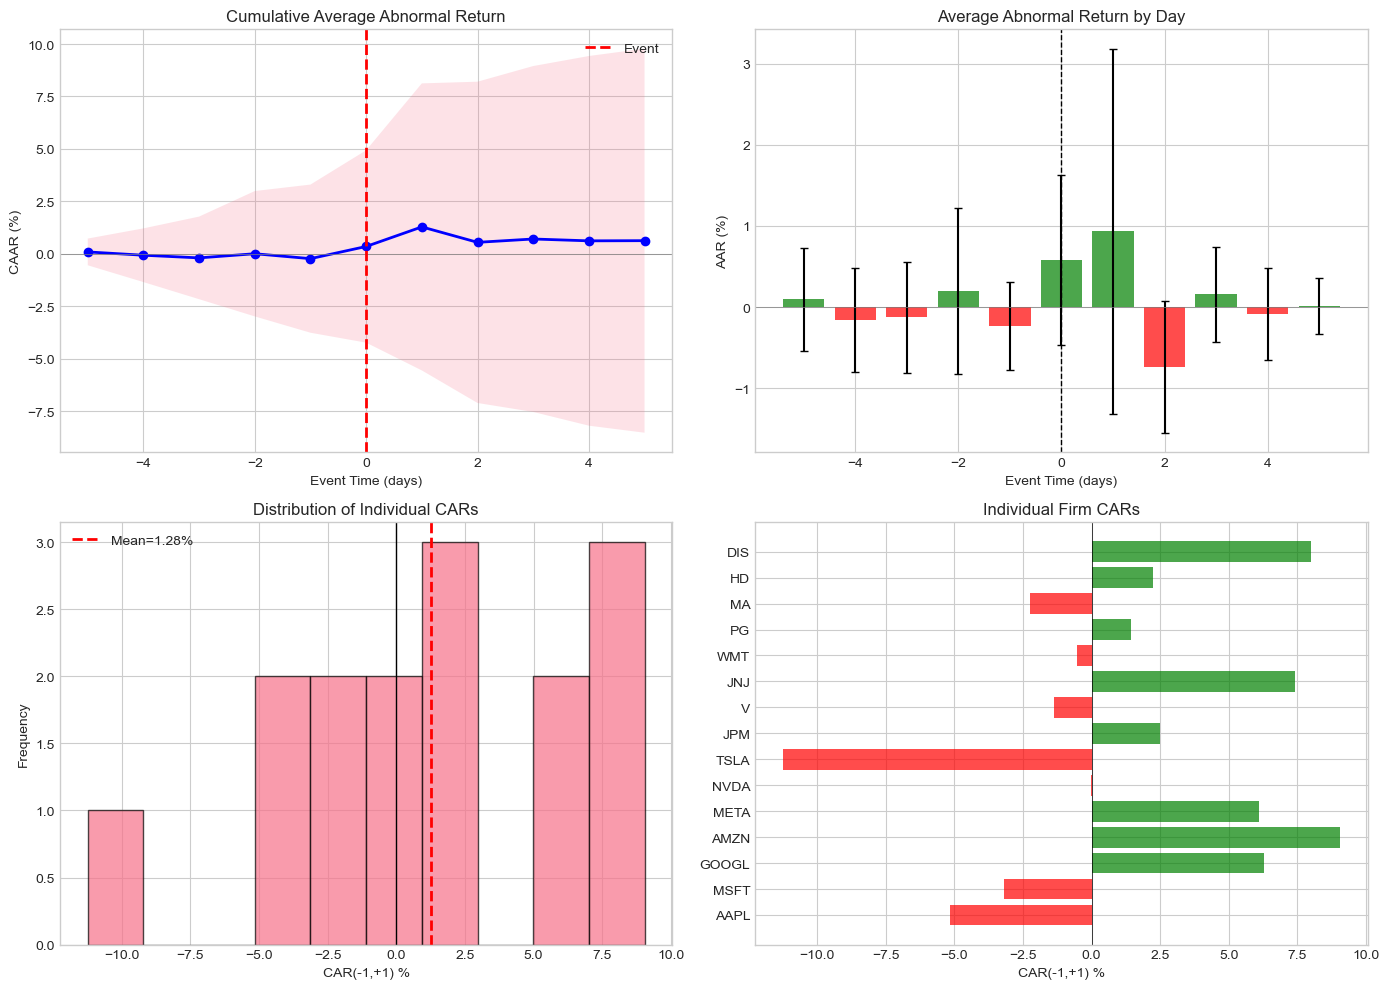

In [17]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get time series data
ts_data = analyzer.get_car_time_series()

# CAAR over event time
ax1 = axes[0, 0]
ax1.plot(ts_data['event_time'], ts_data['CAAR']*100, 'b-', linewidth=2, marker='o')
ax1.fill_between(ts_data['event_time'],
                  (ts_data['CAAR'] - 1.96*ts_data['AAR_se'].cumsum())*100,
                  (ts_data['CAAR'] + 1.96*ts_data['AAR_se'].cumsum())*100,
                  alpha=0.2)
ax1.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Event')
ax1.set_xlabel('Event Time (days)')
ax1.set_ylabel('CAAR (%)')
ax1.set_title('Cumulative Average Abnormal Return')
ax1.legend()

# AAR bar chart
ax2 = axes[0, 1]
colors = ['green' if x > 0 else 'red' for x in ts_data['AAR']]
ax2.bar(ts_data['event_time'], ts_data['AAR']*100, color=colors, alpha=0.7,
        yerr=ts_data['AAR_se']*100*1.96, capsize=3)
ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax2.axvline(0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Event Time (days)')
ax2.set_ylabel('AAR (%)')
ax2.set_title('Average Abnormal Return by Day')

# Individual CAR distribution for (-1,+1)
ax3 = axes[1, 0]
cars = [r.get_car(-1, 1)*100 for r in results if r.valid]
ax3.hist(cars, bins=10, edgecolor='black', alpha=0.7)
ax3.axvline(np.mean(cars), color='red', linestyle='--', linewidth=2, 
            label=f'Mean={np.mean(cars):.2f}%')
ax3.axvline(0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('CAR(-1,+1) %')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Individual CARs')
ax3.legend()

# Individual firm CARs
ax4 = axes[1, 1]
valid_results = [r for r in results if r.valid]
tickers = [r.event.ticker for r in valid_results]
firm_cars = [r.get_car(-1, 1)*100 for r in valid_results]
colors = ['green' if c > 0 else 'red' for c in firm_cars]

y_pos = range(len(tickers))
ax4.barh(y_pos, firm_cars, color=colors, alpha=0.7)
ax4.axvline(0, color='black', linestyle='-', linewidth=0.5)
ax4.set_yticks(y_pos)
ax4.set_yticklabels(tickers)
ax4.set_xlabel('CAR(-1,+1) %')
ax4.set_title('Individual Firm CARs')

plt.tight_layout()
plt.show()

## 4. Robustness Checks

### Why Robustness Matters

Results should be stable across:
1. Different window lengths
2. Different expected return models
3. Subsamples
4. Outlier treatment

In [19]:
class RobustnessChecker:
    """
    Comprehensive robustness checks for event studies.
    """
    
    def __init__(self, events: List[EventData]):
        self.events = events
    
    def model_robustness(self, base_config: EventStudyConfig) -> pd.DataFrame:
        """Test robustness to expected return model choice."""
        models = [
            ExpectedReturnModel.MARKET_MODEL,
            ExpectedReturnModel.MARKET_ADJUSTED,
            ExpectedReturnModel.MEAN_ADJUSTED
        ]
        
        results = []
        for model in models:
            config = EventStudyConfig(
                estimation_window=base_config.estimation_window,
                gap=base_config.gap,
                event_window_pre=base_config.event_window_pre,
                event_window_post=base_config.event_window_post,
                expected_return_model=model
            )
            
            engine = EventStudyEngine(config)
            event_results = engine.process_events(self.events, verbose=False)
            analyzer = EventStudyAnalyzer(event_results)
            
            caar = analyzer.calculate_caar(-1, 1)
            
            results.append({
                'Model': model.value,
                'N': caar['n'],
                'CAAR': caar['caar'],
                't-stat': caar['t_stat'],
                'p-value': caar['p_value']
            })
        
        return pd.DataFrame(results)
    
    def window_robustness(self, base_config: EventStudyConfig) -> pd.DataFrame:
        """Test robustness to estimation window length."""
        windows = [60, 90, 120, 150, 200]
        
        results = []
        for est_window in windows:
            config = EventStudyConfig(
                estimation_window=est_window,
                gap=base_config.gap,
                event_window_pre=base_config.event_window_pre,
                event_window_post=base_config.event_window_post,
                expected_return_model=base_config.expected_return_model,
                min_estimation_obs=min(60, est_window)
            )
            
            engine = EventStudyEngine(config)
            event_results = engine.process_events(self.events, verbose=False)
            analyzer = EventStudyAnalyzer(event_results)
            
            caar = analyzer.calculate_caar(-1, 1)
            
            results.append({
                'Est. Window': est_window,
                'N': caar['n'],
                'CAAR': caar['caar'],
                't-stat': caar['t_stat'],
                'p-value': caar['p_value']
            })
        
        return pd.DataFrame(results)
    
    def outlier_robustness(self, event_results: List[EventResult], 
                           tau1: int = -1, tau2: int = 1) -> Dict:
        """Test robustness to outlier treatment."""
        valid_results = [r for r in event_results if r.valid]
        cars = np.array([r.get_car(tau1, tau2) for r in valid_results])
        
        # Full sample
        full_mean = np.mean(cars)
        full_t = full_mean / (np.std(cars, ddof=1) / np.sqrt(len(cars)))
        
        # Winsorized (1% and 99%)
        p1, p99 = np.percentile(cars, [1, 99])
        winsorized = np.clip(cars, p1, p99)
        wins_mean = np.mean(winsorized)
        wins_t = wins_mean / (np.std(winsorized, ddof=1) / np.sqrt(len(winsorized)))
        
        # Trimmed (exclude top/bottom 5%)
        p5, p95 = np.percentile(cars, [5, 95])
        trimmed = cars[(cars >= p5) & (cars <= p95)]
        trim_mean = np.mean(trimmed)
        trim_t = trim_mean / (np.std(trimmed, ddof=1) / np.sqrt(len(trimmed)))
        
        return {
            'Full Sample': {'N': len(cars), 'CAAR': full_mean, 't-stat': full_t},
            'Winsorized (1-99%)': {'N': len(winsorized), 'CAAR': wins_mean, 't-stat': wins_t},
            'Trimmed (5-95%)': {'N': len(trimmed), 'CAAR': trim_mean, 't-stat': trim_t}
        }


# Run robustness checks
checker = RobustnessChecker(events)

print("\n" + "="*70)
print("ROBUSTNESS CHECKS")
print("="*70)

# Model robustness
print("\n1. Expected Return Model Robustness:")
print("-"*70)
model_robust = checker.model_robustness(config)
model_robust['CAAR'] = model_robust['CAAR'].apply(lambda x: f"{x*100:+.2f}%")
model_robust['t-stat'] = model_robust['t-stat'].apply(lambda x: f"{x:.2f}")
model_robust['p-value'] = model_robust['p-value'].apply(lambda x: f"{x:.4f}")
print(model_robust.to_string(index=False))


ROBUSTNESS CHECKS

1. Expected Return Model Robustness:
----------------------------------------------------------------------
          Model  N   CAAR t-stat p-value
   market_model 15 +1.28%   0.89  0.3898
market_adjusted 15 +1.52%   1.13  0.2766
  mean_adjusted 15 +0.48%   0.34  0.7364


In [21]:
# Window robustness
print("\n2. Estimation Window Robustness:")
print("-"*70)
window_robust = checker.window_robustness(config)
window_robust['CAAR'] = window_robust['CAAR'].apply(lambda x: f"{x*100:+.2f}%")
window_robust['t-stat'] = window_robust['t-stat'].apply(lambda x: f"{x:.2f}")
window_robust['p-value'] = window_robust['p-value'].apply(lambda x: f"{x:.4f}")
print(window_robust.to_string(index=False))


2. Estimation Window Robustness:
----------------------------------------------------------------------



1 Failed download:
['MSFT']: Timeout('Failed to perform, curl: (28) Operation timed out after 10002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


 Est. Window  N   CAAR t-stat p-value
          60 15 +1.32%   0.96  0.3536
          90 14 +1.57%   1.09  0.2948
         120 15 +1.28%   0.89  0.3898
         150 15 +1.34%   0.97  0.3485
         200 15 +1.49%   1.08  0.2966


In [23]:
# Outlier robustness
print("\n3. Outlier Treatment Robustness:")
print("-"*70)
outlier_robust = checker.outlier_robustness(results)
for treatment, stats in outlier_robust.items():
    print(f"  {treatment}: N={stats['N']}, CAAR={stats['CAAR']*100:+.2f}%, t={stats['t-stat']:.2f}")


3. Outlier Treatment Robustness:
----------------------------------------------------------------------
  Full Sample: N=15, CAAR=+1.28%, t=0.89
  Winsorized (1-99%): N=15, CAAR=+1.33%, t=0.95
  Trimmed (5-95%): N=13, CAAR=+1.64%, t=1.39


## 5. Common Pitfalls and How to Avoid Them

In [26]:
def demonstrate_pitfalls():
    """
    Demonstrate common event study pitfalls.
    """
    print("\n" + "="*80)
    print("COMMON EVENT STUDY PITFALLS")
    print("="*80)
    
    # Pitfall 1: Look-ahead bias in event date
    print("\n1. LOOK-AHEAD BIAS")
    print("-"*60)
    print("Problem: Using information not available at event time")
    print("Example: Using close price on announcement day when news")
    print("         came after market close")
    print("Solution: Verify event timing; use t+1 if after-hours")
    
    # Pitfall 2: Survivorship bias
    print("\n2. SURVIVORSHIP BIAS")
    print("-"*60)
    print("Problem: Only including firms that survived")
    print("Example: Studying M&A for current S&P 500 members")
    print("Solution: Use point-in-time data; include delisted firms")
    
    # Pitfall 3: Event date errors
    print("\n3. EVENT DATE ERRORS")
    print("-"*60)
    print("Problem: Using wrong event date (filing vs announcement)")
    print("Example: Using SEC filing date instead of press release")
    print("Solution: Verify dates from multiple sources; check for")
    print("         price reaction to confirm timing")
    
    # Pitfall 4: Thin trading
    print("\n4. THIN TRADING / ILLIQUIDITY")
    print("-"*60)
    print("Problem: Missing or stale prices for illiquid stocks")
    print("Example: Using daily returns with many zero-return days")
    print("Solution: Use trade-to-trade returns; Scholes-Williams beta;")
    print("         exclude extremely illiquid stocks")
    
    # Pitfall 5: Clustering
    print("\n5. EVENT CLUSTERING")
    print("-"*60)
    print("Problem: Many events on same day (e.g., earnings season)")
    print("Example: Testing 50 earnings announcements, 20 on same day")
    print("Solution: Use portfolio approach; crude dependence adjustment;")
    print("         cluster standard errors by date")
    
    # Pitfall 6: Confounding events
    print("\n6. CONFOUNDING EVENTS")
    print("-"*60)
    print("Problem: Multiple events in same window")
    print("Example: Earnings announcement during Fed meeting week")
    print("Solution: Screen for confounding events; use shorter windows;")
    print("         control for confounds in cross-sectional regression")


demonstrate_pitfalls()


COMMON EVENT STUDY PITFALLS

1. LOOK-AHEAD BIAS
------------------------------------------------------------
Problem: Using information not available at event time
Example: Using close price on announcement day when news
         came after market close
Solution: Verify event timing; use t+1 if after-hours

2. SURVIVORSHIP BIAS
------------------------------------------------------------
Problem: Only including firms that survived
Example: Studying M&A for current S&P 500 members
Solution: Use point-in-time data; include delisted firms

3. EVENT DATE ERRORS
------------------------------------------------------------
Problem: Using wrong event date (filing vs announcement)
Example: Using SEC filing date instead of press release
Solution: Verify dates from multiple sources; check for
         price reaction to confirm timing

4. THIN TRADING / ILLIQUIDITY
------------------------------------------------------------
Problem: Missing or stale prices for illiquid stocks
Example: Using dai

In [28]:
def data_quality_checks(results: List[EventResult]) -> pd.DataFrame:
    """
    Perform data quality checks.
    """
    checks = []
    
    for r in results:
        if not r.valid:
            checks.append({
                'Ticker': r.event.ticker,
                'Status': 'FAILED',
                'Issue': r.error_message,
                'Est. N': 'N/A',
                'R²': 'N/A',
                'Beta': 'N/A'
            })
            continue
        
        issues = []
        
        # Check estimation observations
        if r.estimation.n_obs < 100:
            issues.append(f"Low est. obs ({r.estimation.n_obs})")
        
        # Check R-squared
        if r.estimation.r_squared < 0.1:
            issues.append(f"Low R² ({r.estimation.r_squared:.2f})")
        
        # Check beta range
        if r.estimation.beta < 0 or r.estimation.beta > 3:
            issues.append(f"Unusual beta ({r.estimation.beta:.2f})")
        
        # Check for extreme CARs
        car = r.get_car(-1, 1)
        if abs(car) > 0.20:  # 20%
            issues.append(f"Extreme CAR ({car*100:.1f}%)")
        
        checks.append({
            'Ticker': r.event.ticker,
            'Status': 'WARNING' if issues else 'OK',
            'Issue': '; '.join(issues) if issues else 'None',
            'Est. N': r.estimation.n_obs,
            'R²': f"{r.estimation.r_squared:.3f}",
            'Beta': f"{r.estimation.beta:.2f}"
        })
    
    return pd.DataFrame(checks)


# Run quality checks
print("\n" + "="*80)
print("DATA QUALITY CHECKS")
print("="*80)
quality_df = data_quality_checks(results)
print(quality_df.to_string(index=False))


DATA QUALITY CHECKS
Ticker  Status         Issue  Est. N    R² Beta
  AAPL      OK          None     120 0.598 1.12
  MSFT      OK          None     120 0.455 1.31
 GOOGL      OK          None     120 0.374 1.44
  AMZN      OK          None     120 0.371 1.49
  META      OK          None     120 0.327 1.97
  NVDA      OK          None     120 0.219 1.95
  TSLA      OK          None     120 0.278 2.18
   JPM      OK          None     120 0.295 0.92
     V      OK          None     120 0.411 0.76
   JNJ      OK          None     120 0.120 0.37
   WMT WARNING Low R² (0.08)     120 0.076 0.27
    PG      OK          None     120 0.118 0.36
    MA      OK          None     120 0.465 0.83
    HD      OK          None     120 0.370 1.09
   DIS      OK          None     120 0.435 1.30


## 6. Publication-Ready Output

In [30]:
class PublicationFormatter:
    """
    Create publication-ready tables and figures.
    """
    
    @staticmethod
    def main_results_table(analyzer: EventStudyAnalyzer, 
                           windows: List[Tuple[int, int]] = None) -> str:
        """Create main results table."""
        if windows is None:
            windows = [(-1, 1), (0, 0), (-5, 5)]
        
        lines = []
        lines.append("\n" + "="*90)
        lines.append("TABLE: Event Study Results")
        lines.append("="*90)
        lines.append(f"\nSample: {analyzer.n_events} events")
        lines.append("\n" + "-"*90)
        lines.append(f"{'Window':<12} {'CAAR':>10} {'Median':>10} {'t-stat':>10} "
                    f"{'Patell-z':>10} {'%Positive':>10}")
        lines.append("-"*90)
        
        for tau1, tau2 in windows:
            caar = analyzer.calculate_caar(tau1, tau2)
            patell = analyzer.patell_test(tau1, tau2)
            sign = analyzer.sign_test(tau1, tau2)
            
            # Significance markers
            def sig_marker(p):
                if p < 0.01: return '***'
                if p < 0.05: return '**'
                if p < 0.10: return '*'
                return ''
            
            median_car = np.median(caar['cars'])
            
            lines.append(f"({tau1:+d},{tau2:+d}){'':<6} "
                        f"{caar['caar']*100:>+9.2f}%{sig_marker(caar['p_value'])} "
                        f"{median_car*100:>+9.2f}% "
                        f"{caar['t_stat']:>9.2f} "
                        f"{patell['z_stat']:>9.2f} "
                        f"{sign['pct_positive']:>9.1f}%")
        
        lines.append("-"*90)
        lines.append("***, **, * indicate significance at 1%, 5%, 10% levels (two-tailed)")
        
        return '\n'.join(lines)
    
    @staticmethod
    def latex_table(analyzer: EventStudyAnalyzer,
                    windows: List[Tuple[int, int]] = None,
                    caption: str = "Event Study Results") -> str:
        """Generate LaTeX table."""
        if windows is None:
            windows = [(-1, 1), (0, 0), (-5, 5)]
        
        latex = f"""\\begin{{table}}[htbp]
\\centering
\\caption{{{caption}}}
\\begin{{tabular}}{{lccccc}}
\\hline\\hline
Window & N & CAAR & t-stat & Patell z & \\% Positive \\\\
\\hline
"""
        
        for tau1, tau2 in windows:
            caar = analyzer.calculate_caar(tau1, tau2)
            patell = analyzer.patell_test(tau1, tau2)
            sign = analyzer.sign_test(tau1, tau2)
            
            def sig_marker(p):
                if p < 0.01: return '$^{***}$'
                if p < 0.05: return '$^{**}$'
                if p < 0.10: return '$^{*}$'
                return ''
            
            latex += f"({tau1:+d},{tau2:+d}) & {caar['n']} & "
            latex += f"{caar['caar']*100:.2f}\\%{sig_marker(caar['p_value'])} & "
            latex += f"{caar['t_stat']:.2f} & {patell['z_stat']:.2f} & "
            latex += f"{sign['pct_positive']:.1f}\\% \\\\\n"
        
        latex += """\\hline\\hline
\\end{tabular}
\\begin{tablenotes}
\\small
\\item Notes: $^{***}$, $^{**}$, $^{*}$ indicate significance at 1\\%, 5\\%, 10\\% levels.
\\end{tablenotes}
\\end{table}"""
        
        return latex


# Generate publication output
formatter = PublicationFormatter()

print(formatter.main_results_table(analyzer))
print("\n\nLaTeX Code:")
print(formatter.latex_table(analyzer, caption="Earnings Announcement Returns"))

AttributeError: 'dict' object has no attribute 't'

In [ ]:
# Publication-ready figure
def create_publication_figure(analyzer: EventStudyAnalyzer, 
                               save_path: str = None):
    """Create publication-quality figure."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ts_data = analyzer.get_car_time_series()
    
    # Plot CAAR with confidence bands
    ax.plot(ts_data['event_time'], ts_data['CAAR']*100, 'k-', 
            linewidth=2, label='CAAR')
    
    # 95% CI
    cumulative_se = ts_data['AAR_se'].cumsum()
    lower = (ts_data['CAAR'] - 1.96 * cumulative_se) * 100
    upper = (ts_data['CAAR'] + 1.96 * cumulative_se) * 100
    
    ax.fill_between(ts_data['event_time'], lower, upper, 
                    alpha=0.2, color='gray', label='95% CI')
    
    # Reference lines
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    
    # Labels
    ax.set_xlabel('Event Time (Trading Days)', fontsize=12)
    ax.set_ylabel('Cumulative Average Abnormal Return (%)', fontsize=12)
    ax.set_title('Event Study: Cumulative Abnormal Returns', fontsize=14)
    
    # Add annotation for key window
    caar_11 = analyzer.calculate_caar(-1, 1)
    ax.annotate(f'CAAR(-1,+1) = {caar_11["caar"]*100:.2f}%\n(t = {caar_11["t_stat"]:.2f})',
                xy=(1, ts_data[ts_data['event_time'] == 1]['CAAR'].values[0]*100),
                xytext=(3, ts_data[ts_data['event_time'] == 1]['CAAR'].values[0]*100 + 0.5),
                fontsize=10,
                arrowprops=dict(arrowstyle='->', color='black'))
    
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    plt.show()


create_publication_figure(analyzer)

## 7. Checklist for Event Study Research

In [33]:
def print_research_checklist():
    """Print comprehensive research checklist."""
    checklist = """
╔══════════════════════════════════════════════════════════════════════════════╗
║                    EVENT STUDY RESEARCH CHECKLIST                           ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  □ RESEARCH DESIGN                                                           ║
║    □ Clear research question and hypothesis                                  ║
║    □ Appropriate event type for question                                     ║
║    □ Justified window lengths                                                ║
║    □ Expected return model appropriate for setting                           ║
║                                                                              ║
║  □ DATA COLLECTION                                                           ║
║    □ Event dates verified from multiple sources                              ║
║    □ Point-in-time data (no survivorship bias)                               ║
║    □ Sufficient estimation period observations                               ║
║    □ Adjusted for splits, dividends                                          ║
║                                                                              ║
║  □ IMPLEMENTATION                                                            ║
║    □ Data quality checks performed                                           ║
║    □ Outliers identified and handled                                         ║
║    □ Confounding events screened                                             ║
║    □ Event clustering addressed                                              ║
║                                                                              ║
║  □ STATISTICAL TESTING                                                       ║
║    □ Multiple test statistics reported                                       ║
║    □ Both parametric and non-parametric tests                                ║
║    □ Cross-sectional standard errors appropriate                             ║
║    □ Bootstrap inference for small samples                                   ║
║                                                                              ║
║  □ ROBUSTNESS                                                                ║
║    □ Different window lengths                                                ║
║    □ Different expected return models                                        ║
║    □ Outlier treatment sensitivity                                           ║
║    □ Subsample analysis                                                      ║
║                                                                              ║
║  □ REPORTING                                                                 ║
║    □ Sample construction transparent                                         ║
║    □ Methodology clearly described                                           ║
║    □ Multiple windows reported                                               ║
║    □ Economic significance discussed                                         ║
║    □ Limitations acknowledged                                                ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""
    print(checklist)


print_research_checklist()


╔══════════════════════════════════════════════════════════════════════════════╗
║                    EVENT STUDY RESEARCH CHECKLIST                           ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  □ RESEARCH DESIGN                                                           ║
║    □ Clear research question and hypothesis                                  ║
║    □ Appropriate event type for question                                     ║
║    □ Justified window lengths                                                ║
║    □ Expected return model appropriate for setting                           ║
║                                                                              ║
║  □ DATA COLLECTION                                                           ║
║    □ Event dates verified from multiple sources                              ║
║    □ Point-in-time data (n

## 8. Summary

### Key Takeaways

1. **Design carefully**: Window lengths, models, and tests should match your question

2. **Build robust code**: Modular, flexible, handles edge cases

3. **Check data quality**: Verify dates, screen for issues

4. **Test robustness**: Results should be stable across specifications

5. **Avoid pitfalls**: Look-ahead bias, survivorship, clustering

6. **Report comprehensively**: Multiple windows, tests, robustness checks

### The Framework Provided

- `EventStudyConfig`: Configurable parameters
- `EventStudyEngine`: Data processing and estimation
- `EventStudyAnalyzer`: Statistical analysis
- `RobustnessChecker`: Sensitivity analysis
- `PublicationFormatter`: Output generation

## References

- MacKinlay, A. C. (1997). Event studies in economics and finance. *Journal of Economic Literature*, 35(1), 13-39.
- Kothari, S. P., & Warner, J. B. (2007). Econometrics of event studies. *Handbook of Corporate Finance*, 1, 3-36.
- Kolari, J. W., & Pynnönen, S. (2010). Event study testing with cross-sectional correlation of abnormal returns. *Review of Financial Studies*, 23(11), 3996-4025.